In [3]:
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['font.size'] = 12

import av
import nems_lbhb.pup_py.utils as ut
from nems_lbhb.baphy_experiment import BAPHYExperiment

In [6]:
manager = BAPHYExperiment(cellid="CRD018d", batch=331)
parmfiles = manager.parmfile

In [13]:
videos = [str(p).replace(".m", ".avi") for p in parmfiles]
nframes = 0
for video in videos:
    container = av.open(video)
    video_stream = [s for s in container.streams][0]
    for packet in container.demux(video_stream):
        nframes+=1


In [15]:
data = np.zeros((224*224, nframes))
idx = 0
for video in videos:
    container = av.open(video)
    video_stream = [s for s in container.streams][0]
    for i, packet in enumerate(container.demux(video_stream)):
        try:
            frame = packet.decode()[0]

            frame_ = np.asarray(frame.to_image().convert('LA'))
            frame_ = frame_[:, :-10, :]
            frame_ = frame_ - np.min(frame_)

            size = (224, 224)
            sf, im = ut.resize(frame_, size=size)

            data[:, idx] = im[:, :, 0].flatten()
            if i % 1000 == 0:
                print("frame: {0}/{1}...".format(i, nframes))
        except:
            print(f"couldn't decode frame {i}")
        
        idx+=1

[libav.swscaler WARNING] deprecated pixel format used, make sure you did set range correctly


couldn't decode frame 0
couldn't decode frame 1
frame: 1000/9893...
frame: 2000/9893...
frame: 3000/9893...
frame: 4000/9893...
frame: 5000/9893...
frame: 6000/9893...
frame: 7000/9893...
frame: 8000/9893...
frame: 9000/9893...


In [16]:
pca = IncrementalPCA(batch_size=200)
pca.fit(data.T)

/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/auto/users/hellerc/anaconda3/envs/lbhb/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IncrementalPCA(batch_size=200)

In [20]:
projection = data[:, :].T.dot(pca.components_[[1], :].T)
transform = projection.dot(pca.components_[[1], :])

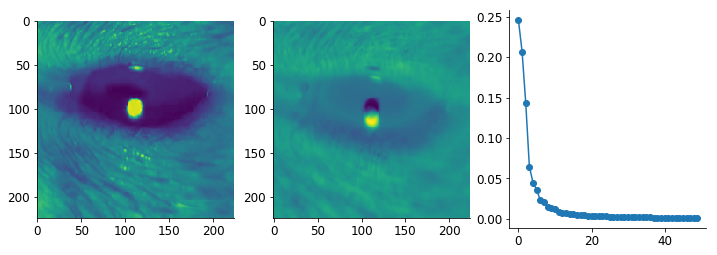

In [21]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(data[:, 2].reshape(224, 224))
ax[1].imshow(transform[2, :].reshape(224, 224))
ax[2].plot(pca.explained_variance_ratio_[:50], "o-")

In [19]:
options = {'rasterfs': 4, 'resp': True, 'stim': False, 'pupil': True, 'pupil_variable_name': 'area', "verbose": False}
rec = manager.get_recording(**options)
pupil = rec["pupil"]._data[0, :]

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/331/CRD018d_f21c2783030d7594f521db52a91cdf29ad5145df.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


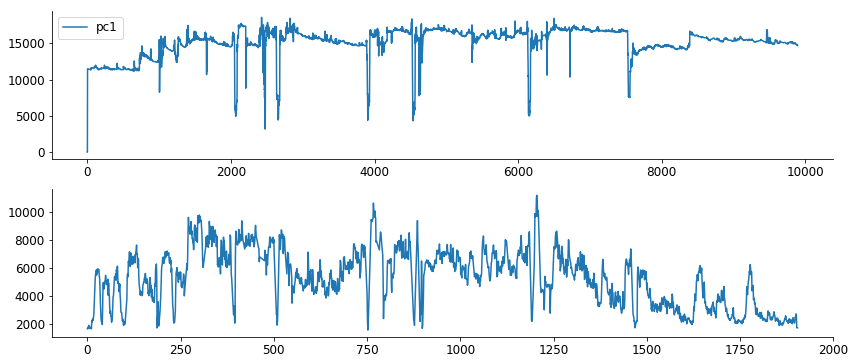

In [23]:
f, ax = plt.subplots(2, 1, figsize=(14, 6))
ax[0].plot(projection[:, 0], label="pc1")
# ax[0].plot(projection[:, 1], label="pc2")
# ax[0].plot(projection[:, 2], label="pc3")
ax[0].legend()
ax[1].plot(pupil)